# Standard Step Method - GVF with Sluice Gate
本教學示範展示如何以 Python 解出經典渠道逐漸變動流（GVF）問題，並含有：
* 閘門產生的束縮流（vertical contraction only）
* 上游 M1 曲線積分（subcritical profile）
* 閘門下游 S2 曲線積分（supercritical profile）
* 水躍（hydraulic jump）位置偵測
* 加入 Normal depth 與 Critical depth 線作為基準對照

## 計算方法

上游水面線（M1 曲線）為亞臨界流，計算水深變化所用的方程式是能量方程：

### 上游水面線計算方程式（能量形式）

對於任兩斷面（1 與 2），距離為 $\Delta x$，床坡為 $S_0$，水面線計算使用：

$$
z_1 + y_1 + \frac{\alpha_1 V_1^2}{2g}
\;=\;
z_2 + y_2 + \frac{\alpha_2 V_2^2}{2g}
\;+\;
h_f
$$

其中：
- $z_1$, $z_2$：渠底高程（通常 $z_2 = z_1 - S_0 \Delta x$）
- $y_1$, $y_2$：水深（$y_1$ 已知，$y_2$ 為待解）
- $V_1 = Q / (b y_1),\quad V_2 = Q / (b y_2)$：平均流速
- $\alpha_1$, $\alpha_2$：動能修正係數（取 1.0–1.1）
- $h_f = S_f^{\text{avg}} \cdot \Delta x$：摩擦損失，取上下游平均摩擦坡降

### 摩擦坡降（以 Manning's formula 表示）

$$
S_f(y) = \left( \frac{Q \cdot n}{A R^{2/3}} \right)^2
\quad
\text{其中：}
A = b y,\quad R = \frac{A}{P} = \frac{b y}{b + 2y}
$$

### 整理後的未知量方程（以 $y_2$ 為未知）

定義上游能量線：

$$
H_1 = z_1 + y_1 + \frac{V_1^2}{2g}
$$

則 $y_2$ 滿足：

$$
H_1 = z_2 + y_2 + \frac{V_2^2}{2g} + S_f^{\text{avg}} \cdot \Delta x
$$

這是一個非線性方程式，需用數值方法（如牛頓法）解出 $y_2$。此即所謂的 Standard Step Method，一段一段往下游積分。

### 簡化表達（以 $E(y)$ 表示 specific energy）

$$
E(y) = y + \frac{V(y)^2}{2g} = y + \frac{Q^2}{2g b^2 y^2}
$$

則計算公式可寫為：

$$
z_1 + E(y_1) = z_2 + E(y_2) + \frac{1}{2}\left[ {S_f(y_1) + S_f(y_2)}\right] \Delta x
$$

這是程式中實作的核心方程式形式。

## 1. 問題參數

In [1]:
import math, numpy as np, matplotlib.pyplot as plt

g  = 9.81          # 重力加速度
b  = 5.0           # 渠道寬度 (m)
S0 = 5e-4          # 底坡
n  = 0.012         # Manning 糙率
Q  = 5.0           # 流量 (m³/s)
x_gate = 2000.0    # 閘門位置 (m)
a  = 0.80          # 閘門開度 (m) (0.7)
Cc = 0.60          # 收縮係數 (vertical only)
y0 = 0.80          # 水庫深度 (m) (3.50)
dx_sub = 10.0      # 上游積分步距
dx_sup = 0.05      # 下游積分步距

## 2. 輔助函式

In [2]:
def conveyance(y):
    A = b*y
    P = b + 2*y
    R = A/P
    return (1/n)*A*R**(2/3)

def Sf(y):
    return (Q/conveyance(y))**2

def specific_energy(y):
    V = Q/(b*y)
    return y + V**2/(2*g)

def newton(y_init, func):
    y = y_init
    for _ in range(30):
        f = func(y)
        if abs(f) < 1e-10:
            break
        dy = max(1e-6, 1e-4*y)
        df = (func(y+dy)-f)/dy
        y -= f/df
        y = max(y, 1e-4)
    return y

## 3. Normal 與 Critical depth 求解

In [3]:
# 臨界水深 (rectangular): Q^2/(g b^2) = y^3
y_crit = (Q**2/(g*b**2))**(1/3)

# 正常水深：Sf(y) = S0
y_norm = newton(1.0, lambda y: Sf(y) - S0)
print(f"Critical depth y_c = {y_crit:.3f} m")
print(f"Normal depth   y_n = {y_norm:.3f} m")

Critical depth y_c = 0.467 m
Normal depth   y_n = 0.766 m


## 4. 上游 M1 曲線積分

In [4]:
x_sub = [0.0]; y_sub = [y0]; z_sub = [0.0]
while x_sub[-1] + dx_sub < x_gate - 1e-6:
    x1, y1, z1 = x_sub[-1], y_sub[-1], z_sub[-1]
    x2 = x1 + dx_sub
    z2 = -S0 * x2
    func = lambda y2: z1 + specific_energy(y1) - (z2 + specific_energy(y2)) - 0.5*(Sf(y1)+Sf(y2))*dx_sub
    y2 = newton(y1, func)
    x_sub.append(x2); y_sub.append(y2); z_sub.append(z2)
y_u = y_sub[-1]

## 5. 閘門下游深度估算


### 閘門下游水深估算（估算初始超臨界深度）

#### 假設條件

- 閘門位置: 垂直束縮，開度為 a，全跨渠寬 b
- 流況: 上游為亞臨界（高水位），閘門下游為超臨界自由流
- 流量 Q: 已知，或由上游深度 y_u 與閘門公式計算得知
- 收縮係數 $C_c$: 用來估算收縮段（vena contracta）之水深


### 步驟與公式

#### 步驟 1：計算收縮段深度與比能

估收縮段（vena contracta）水深與流速：

$$
y_c = C_c \cdot a
\qquad
V_c = \frac{Q}{b\,y_c}
$$

$$
E_c = y_c + \frac{V_c^2}{2g}
$$

#### 步驟 2：由能量守恆估算下游第一個超臨界深度 y_d

假設能量線從收縮段平滑延伸至下游水面，即滿足：

$$
E_c = y_d + \frac{Q^2}{2g\,b^2\,y_d^2}
$$

此為非線性方程，整理為三次多項式：

$$
y_d^3 - E_c y_d^2 + \frac{Q^2}{2g\,b^2} = 0
$$

### 解法

使用數值方法（如 NumPy roots、牛頓法）解上式。取實數正根中最小者（對應超臨界流況）作為估算值：

$$
y_d = \min\left\{ \text{RealPositiveRoots} \right\}
$$

### 收縮係數 C_c 推薦值

對於單純 垂直束縮，可用經驗式：

$$
C_c \approx 0.611 + 0.08 \cdot \frac{a}{y_u}
\quad \text{（上限約 0.68）}
$$

若無上游水深，可先採 C_c = 0.64 作粗估。

### 總結公式整理

收縮段水深與速度

$$
y_c = C_c a,
\quad
V_c = \frac{Q}{b y_c},
\quad
E_c = y_c + \frac{V_c^2}{2g}
$$

閘門下游超臨界深度 $$y_d$$（由能量線延伸）

$$
y_d^3 - E_c y_d^2 + \frac{Q^2}{2g b^2} = 0
\quad\Rightarrow\quad
\text{求實數正根中較小者}
$$

### 備註與限制
- 上述方法忽略了局部擴散損失與射流旋渦，故僅為估算。
- 若需更嚴謹分析，應加入「突擴能損」或用動量法進行水躍檢核。
- 本法適合作為 GVF 中 S₂ 曲線初始深度之估算起點。

In [5]:
y_c = Cc * a
V_c = Q / (b * y_c)
E_c = y_c + V_c**2 / (2*g)
coeffs = [1.0, -E_c, 0.0, Q**2 / (2*g*b**2)]
roots = [r.real for r in np.roots(coeffs) if abs(r.imag) < 1e-9 and r.real > 0]
y_d = min(roots)
print(f"Gate downstream supercritical depth y_d = {y_d:.3f} m")

Gate downstream supercritical depth y_d = 0.455 m


## 6. 閘門下游 S2 曲線與水躍偵測

In [6]:
x_sup = [x_gate + 1.0]; y_sup = [y_d]; z_sup = [-S0*(x_gate+1.0)]
found_jump = False
while x_sup[-1]-x_gate < 400.0:
    x1, y1, z1 = x_sup[-1], y_sup[-1], z_sup[-1]
    x2 = x1 + dx_sup
    z2 = -S0 * x2
    func = lambda y2: z1 + specific_energy(y1) - (z2 + specific_energy(y2)) - 0.5*(Sf(y1)+Sf(y2))*dx_sup
    y2 = newton(y1, func)
    x_sup.append(x2); y_sup.append(y2); z_sup.append(z2)
    Fr = Q/(b*y2)/math.sqrt(g*y2)
    y_conj = y2/2*(math.sqrt(1+8*Fr**2)-1)
    if y2 >= y_conj:
        found_jump = True
        break

## 7. 畫出水面線、正常水深、臨界水深

### 全河段

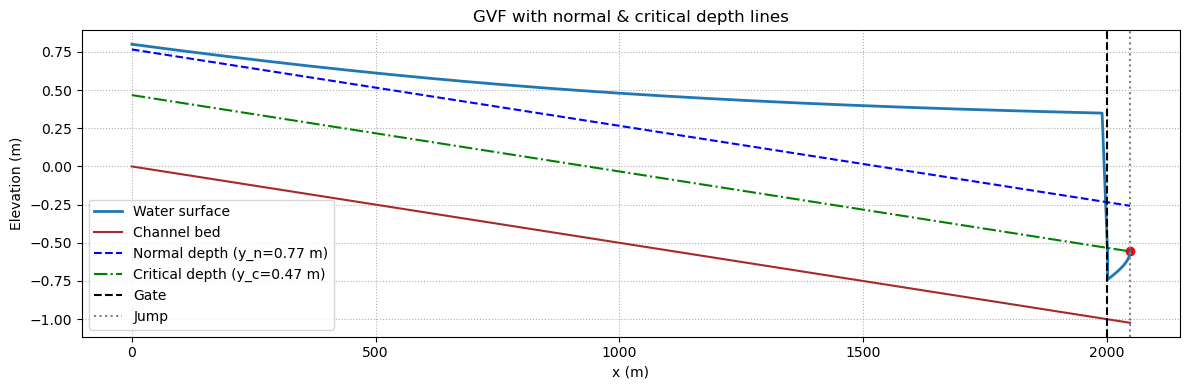

In [7]:
X_ws = np.concatenate((np.array(x_sub), np.array(x_sup)))
Y_ws = np.concatenate((np.array([z+y for z,y in zip(z_sub,y_sub)]),
                       np.array([z+y for z,y in zip(z_sup,y_sup)])))
X_bed = np.linspace(0, X_ws[-1], 500)
Y_bed = -S0 * X_bed
Y_norm_line = Y_bed + y_norm
Y_crit_line = Y_bed + y_crit

plt.figure(figsize=(12,4))
plt.plot(X_ws, Y_ws, lw=2, label='Water surface')
plt.plot(X_bed, Y_bed, color='brown', label='Channel bed')
plt.plot(X_bed, Y_norm_line, ls='--', color='blue', label=f'Normal depth (y_n={y_norm:.2f} m)')
plt.plot(X_bed, Y_crit_line, ls='-.', color='green', label=f'Critical depth (y_c={y_crit:.2f} m)')
plt.axvline(x_gate, ls='--', color='k', label='Gate')
if found_jump:
    plt.axvline(x_sup[-1], ls=':', color='grey', label='Jump')
    plt.scatter([x_sup[-1]], [y_sup[-1]+z_sup[-1]], color='red')
plt.title('GVF with normal & critical depth lines')
plt.xlabel('x (m)'); plt.ylabel('Elevation (m)')
plt.grid(True, ls=':'); plt.legend(); plt.tight_layout()
plt.show()

### 閘門下游

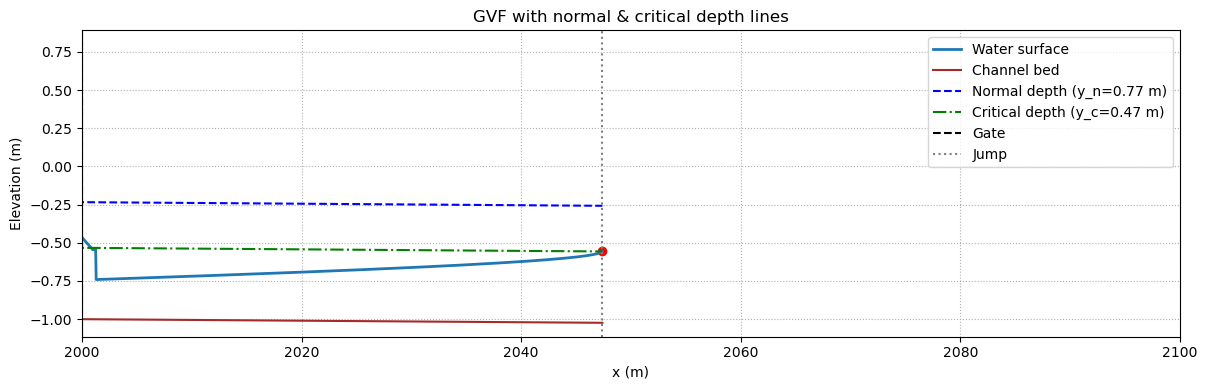

In [8]:
plt.figure(figsize=(12,4))
plt.plot(X_ws, Y_ws, lw=2, label='Water surface')
plt.plot(X_bed, Y_bed, color='brown', label='Channel bed')
plt.plot(X_bed, Y_norm_line, ls='--', color='blue', label=f'Normal depth (y_n={y_norm:.2f} m)')
plt.plot(X_bed, Y_crit_line, ls='-.', color='green', label=f'Critical depth (y_c={y_crit:.2f} m)')
plt.axvline(x_gate, ls='--', color='k', label='Gate')
if found_jump:
    plt.axvline(x_sup[-1], ls=':', color='grey', label='Jump')
    plt.scatter([x_sup[-1]], [y_sup[-1]+z_sup[-1]], color='red')
plt.title('GVF with normal & critical depth lines')
plt.xlabel('x (m)'); plt.ylabel('Elevation (m)')
plt.grid(True, ls=':'); plt.legend(); plt.tight_layout()
plt.xlim(2000,2100)
plt.show()